# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

/home/leticia/anaconda3/envs/RoboNDgpu/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/leticia/anaconda3/envs/RoboNDgpu/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/leticia/anaconda3/envs/RoboNDgpu/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    # Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm( input_layer, filters, strides )
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    ## print( 'LOGS START **********' )
    ## print( 'smallShape: ', small_ip_layer.get_shape().as_list() )
    ## print( 'largeShape: ', large_ip_layer.get_shape().as_list() )
    # Upsample the small input layer using the bilinear_upsample() function.
    _upsampled_ip_layer = bilinear_upsample( small_ip_layer )
    ## print( 'upShape: ', _upsampled_ip_layer.get_shape().as_list() )
    ## print( 'LOGS END ************' )
    # Concatenate the upsampled and large input layers using layers.concatenate
    _concat_layer = layers.concatenate( [ _upsampled_ip_layer, large_ip_layer ] )
    # Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm( _concat_layer, filters )
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:

def vgg_max_pooling_layer( inputs ) :
    _layer = layers.MaxPooling2D( pool_size = ( 2, 2 ), strides = ( 2, 2 ) )( inputs )
    return _layer

def showShape( mlayer, name = '' ) :
    print( name + ' : ', mlayer.get_shape().as_list() )

def fcn_vgg_model( inputs, num_classes ) :
    print( 'LOG> model ********' )
    _conv1 = encoder_block( inputs, 32, 1 )
    showShape( _conv1, '_conv1' )
    _pool1 = vgg_max_pooling_layer( _conv1 )
    showShape( _pool1, '_pool1' )
    
    _conv2 = encoder_block( _pool1, 64, 1 )
    showShape( _conv2, '_conv2' )
    _pool2 = vgg_max_pooling_layer( _conv2 )
    showShape( _pool2, '_pool2' )
    
    _conv3 = encoder_block( _pool2, 128, 1 )
    showShape( _conv3, '_conv3' )
    _conv4 = encoder_block( _conv3, 128, 1 )
    showShape( _conv4, '_conv4' )
    _pool3 = vgg_max_pooling_layer( _conv4 )
    showShape( _pool3, '_pool3' )
    
    _conv5 = encoder_block( _pool3, 256, 1 )
    showShape( _conv5, '_conv5' )
    _conv6 = encoder_block( _conv5, 256, 1 )
    showShape( _conv6, '_conv6' )
    _pool4 = vgg_max_pooling_layer( _conv6 )
    showShape( _pool4, '_pool4' )
    
    _conv7 = encoder_block( _pool4, 256, 1 )
    showShape( _conv7, '_conv7' )
    _conv8 = encoder_block( _conv7, 256, 1 )
    showShape( _conv8, '_conv8' )
    _pool5 = vgg_max_pooling_layer( _conv8 )
    showShape( _pool5, '_pool5' )
    
    _mid = conv2d_batchnorm( _pool5, 512, 1 )
    showShape( _mid, '_mid' )
    
    _tconv1 = decoder_block( _mid, _pool4, 256 )
    showShape( _tconv1, '_tconv1' )
    _tconv2 = decoder_block( _tconv1, _pool3, 256 )
    showShape( _tconv2, '_tconv2' )
    _tconv3 = decoder_block( _tconv2, _pool2, 128 )
    showShape( _tconv3, '_tconv3' )
    _tconv4 = decoder_block( _tconv3, _pool1, 64 )
    showShape( _tconv4, '_tconv4' )
    
    x = decoder_block( _tconv4, inputs, 32 )
    showShape( x, 'x' )
    return layers.Conv2D( num_classes, 3, activation = 'softmax', padding = 'same' )(x)
    

def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    _conv1 = encoder_block( inputs, 32, 2 )
    _conv2 = encoder_block( _conv1, 64, 2 )
    _conv3 = encoder_block( _conv2, 128, 2 )
    # print( 'LOGS Encoder blocks********' )
    # print( 'conv1: ', _conv1.get_shape().as_list() )
    # print( 'conv2: ', _conv2.get_shape().as_list() )
    # print( 'conv3: ', _conv3.get_shape().as_list() )
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    _mid = conv2d_batchnorm( _conv3, 256, 1 )
    # print( '1x1conv: ', _mid.get_shape().as_list() )
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    # print( 'dec 1' )
    _dec1 = decoder_block( _mid, _conv2, 128 )
    # print( 'dec 2' )
    _dec2 = decoder_block( _dec1, _conv1, 64 )
    # print( 'dec 3' )
    x = decoder_block( _dec2, inputs, 32 )
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
# output_layer = fcn_model(inputs, num_classes)
output_layer = fcn_vgg_model(inputs, num_classes)

LOG> model ********
_conv1 :  [None, 160, 160, 32]
_pool1 :  [None, 80, 80, 32]
_conv2 :  [None, 80, 80, 64]
_pool2 :  [None, 40, 40, 64]
_conv3 :  [None, 40, 40, 128]
_conv4 :  [None, 40, 40, 128]
_pool3 :  [None, 20, 20, 128]
_conv5 :  [None, 20, 20, 256]
_conv6 :  [None, 20, 20, 256]
_pool4 :  [None, 10, 10, 256]
_conv7 :  [None, 10, 10, 256]
_conv8 :  [None, 10, 10, 256]
_pool5 :  [None, 5, 5, 256]
_mid :  [None, 5, 5, 512]
_tconv1 :  [None, 10, 10, 256]
_tconv2 :  [None, 20, 20, 256]
_tconv3 :  [None, 40, 40, 128]
_tconv4 :  [None, 80, 80, 64]
x :  [None, 160, 160, 32]


### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [8]:
num_training_samples = 154131
num_validation_samples = 1184

learning_rate = 0.0005
batch_size = 32
num_epochs = 75
steps_per_epoch = int( num_training_samples / batch_size )
validation_steps = int( num_validation_samples / batch_size )
workers = 2

num image files:  154131
num mask files:  154131
num image files:  1184
num mask files:  1184
Epoch 1/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0352

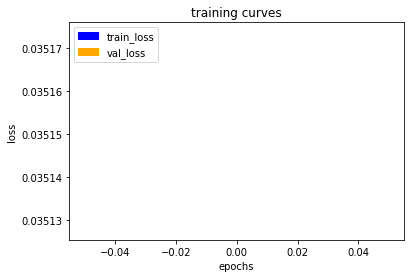

4816/4816 [==============================] - 2575s - loss: 0.0352 - val_loss: 0.0351
Epoch 2/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0112

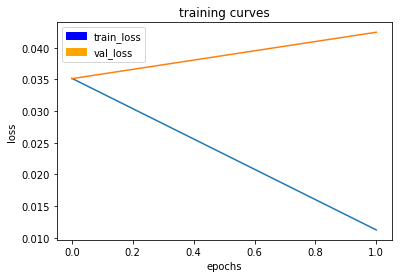

4816/4816 [==============================] - 2552s - loss: 0.0112 - val_loss: 0.0425
Epoch 3/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0100

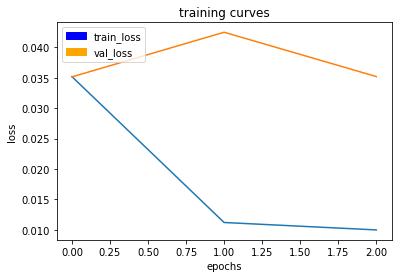

4816/4816 [==============================] - 2548s - loss: 0.0100 - val_loss: 0.0352
Epoch 4/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0092

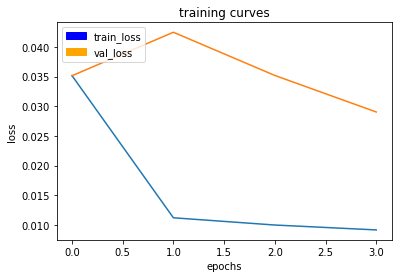

4816/4816 [==============================] - 2548s - loss: 0.0092 - val_loss: 0.0290
Epoch 5/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0087

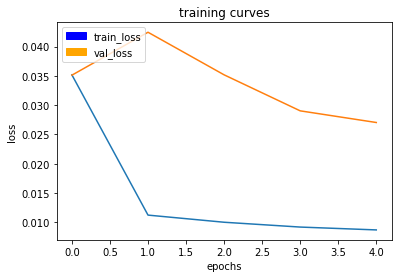

Epoch 00004: saving model to _training/cp-0004.ckpt
4816/4816 [==============================] - 2546s - loss: 0.0087 - val_loss: 0.0270
Epoch 6/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0084

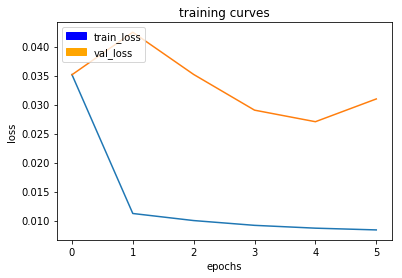

4816/4816 [==============================] - 2542s - loss: 0.0084 - val_loss: 0.0310
Epoch 7/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0081

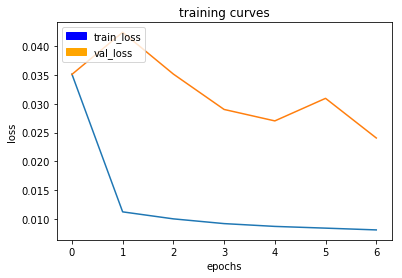

4816/4816 [==============================] - 2542s - loss: 0.0081 - val_loss: 0.0241
Epoch 8/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0078

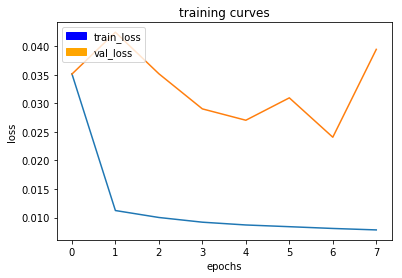

4816/4816 [==============================] - 2540s - loss: 0.0078 - val_loss: 0.0395
Epoch 9/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0078

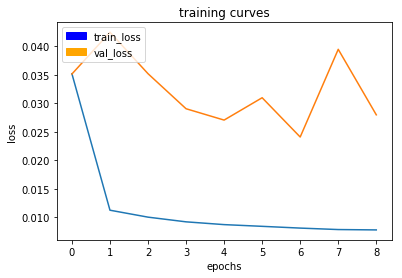

4816/4816 [==============================] - 2539s - loss: 0.0078 - val_loss: 0.0280
Epoch 10/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0076

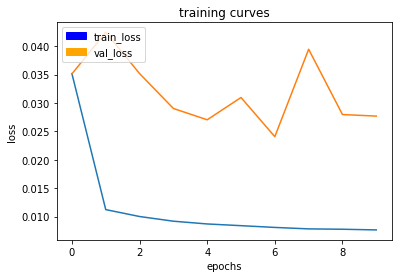

Epoch 00009: saving model to _training/cp-0009.ckpt
4816/4816 [==============================] - 2537s - loss: 0.0076 - val_loss: 0.0277
Epoch 11/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0075

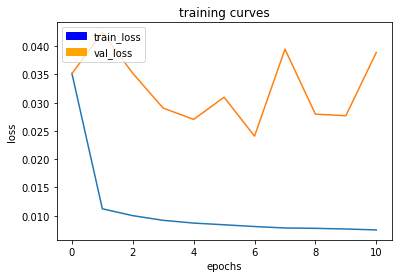

4816/4816 [==============================] - 2533s - loss: 0.0075 - val_loss: 0.0389
Epoch 12/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0075

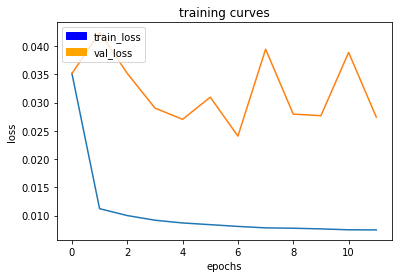

4816/4816 [==============================] - 2533s - loss: 0.0075 - val_loss: 0.0274
Epoch 13/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0075

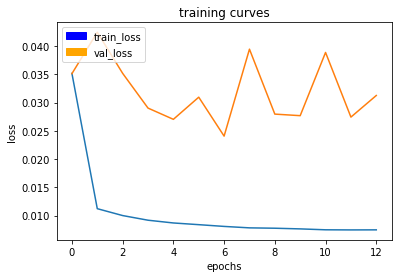

4816/4816 [==============================] - 2532s - loss: 0.0075 - val_loss: 0.0313
Epoch 14/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0073

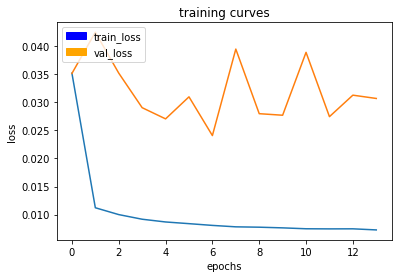

4816/4816 [==============================] - 2531s - loss: 0.0073 - val_loss: 0.0307
Epoch 15/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0072

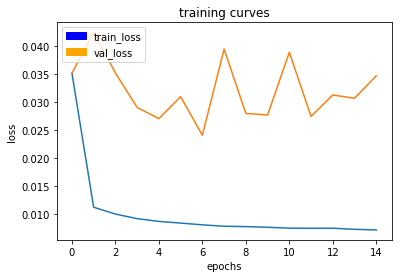

Epoch 00014: saving model to _training/cp-0014.ckpt
4816/4816 [==============================] - 2530s - loss: 0.0072 - val_loss: 0.0347
Epoch 16/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0071

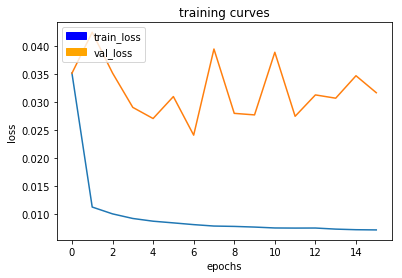

4816/4816 [==============================] - 2532s - loss: 0.0071 - val_loss: 0.0317
Epoch 17/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0072

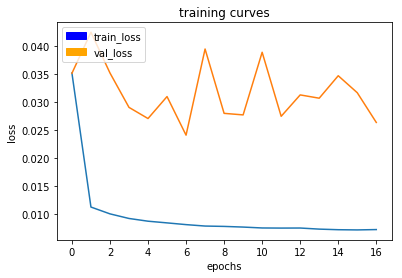

4816/4816 [==============================] - 2531s - loss: 0.0072 - val_loss: 0.0263
Epoch 18/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0070

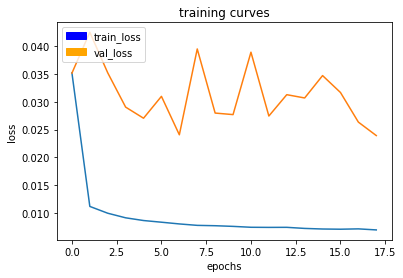

4816/4816 [==============================] - 2529s - loss: 0.0070 - val_loss: 0.0239
Epoch 19/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0070

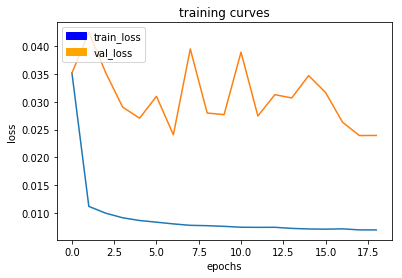

4816/4816 [==============================] - 2529s - loss: 0.0070 - val_loss: 0.0239
Epoch 20/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0069

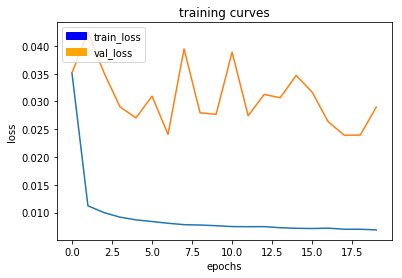

Epoch 00019: saving model to _training/cp-0019.ckpt
4816/4816 [==============================] - 2528s - loss: 0.0069 - val_loss: 0.0290
Epoch 21/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0068

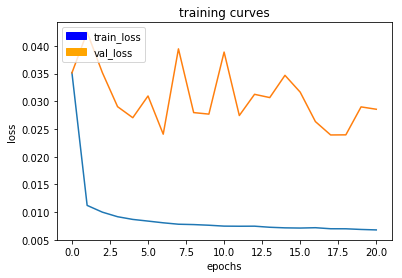

4816/4816 [==============================] - 2527s - loss: 0.0068 - val_loss: 0.0286
Epoch 22/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0068

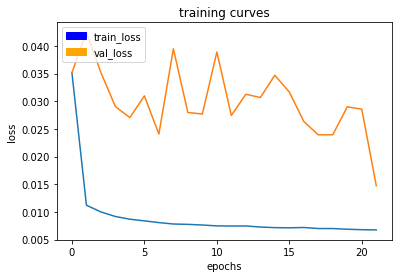

4816/4816 [==============================] - 2528s - loss: 0.0068 - val_loss: 0.0147
Epoch 23/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0067

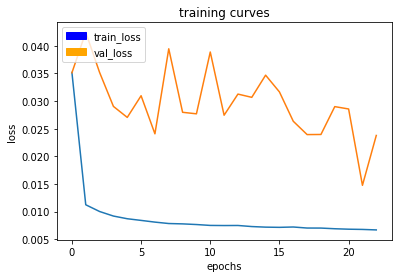

4816/4816 [==============================] - 2528s - loss: 0.0067 - val_loss: 0.0238
Epoch 24/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0066

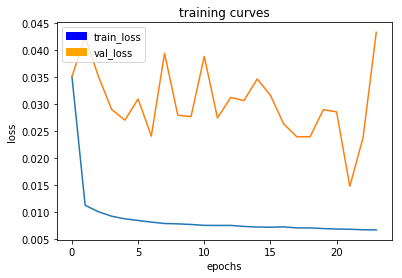

4816/4816 [==============================] - 2529s - loss: 0.0066 - val_loss: 0.0434
Epoch 25/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0065

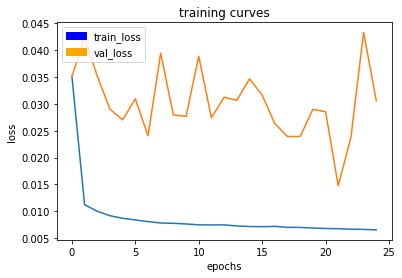

Epoch 00024: saving model to _training/cp-0024.ckpt
4816/4816 [==============================] - 2528s - loss: 0.0065 - val_loss: 0.0306
Epoch 26/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0065

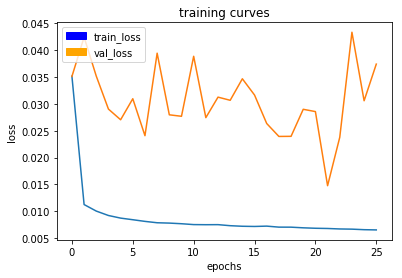

4816/4816 [==============================] - 2528s - loss: 0.0065 - val_loss: 0.0374
Epoch 27/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0064

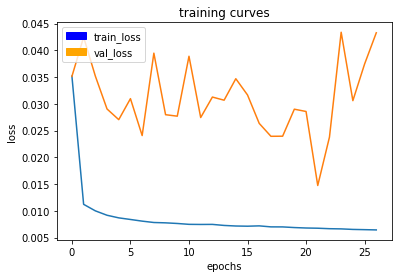

4816/4816 [==============================] - 2527s - loss: 0.0064 - val_loss: 0.0433
Epoch 28/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0064

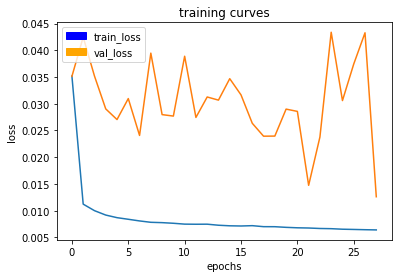

4816/4816 [==============================] - 2527s - loss: 0.0064 - val_loss: 0.0126
Epoch 29/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0064

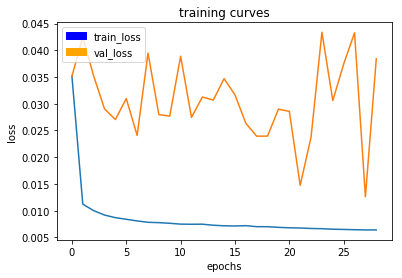

4816/4816 [==============================] - 2526s - loss: 0.0064 - val_loss: 0.0384
Epoch 30/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0064

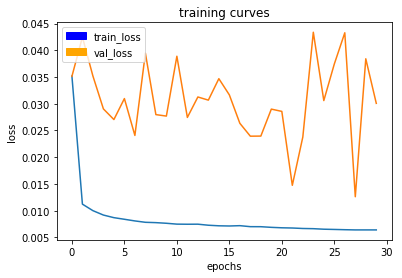

Epoch 00029: saving model to _training/cp-0029.ckpt
4816/4816 [==============================] - 2525s - loss: 0.0064 - val_loss: 0.0301
Epoch 31/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0063

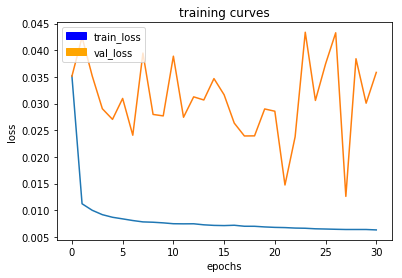

4816/4816 [==============================] - 2526s - loss: 0.0063 - val_loss: 0.0358
Epoch 32/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0063

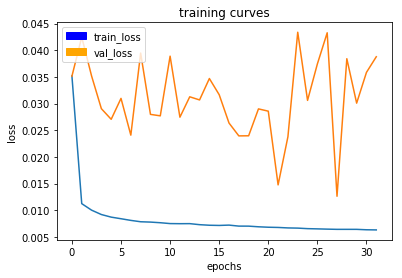

4816/4816 [==============================] - 2525s - loss: 0.0063 - val_loss: 0.0388
Epoch 33/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0063

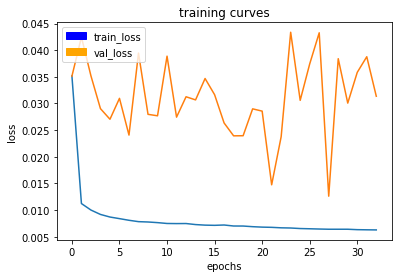

4816/4816 [==============================] - 2525s - loss: 0.0063 - val_loss: 0.0314
Epoch 34/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0063

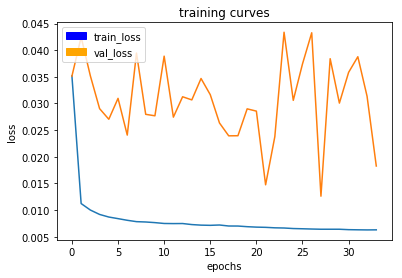

4816/4816 [==============================] - 2525s - loss: 0.0063 - val_loss: 0.0183
Epoch 35/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0062

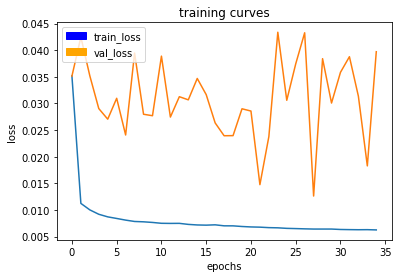

Epoch 00034: saving model to _training/cp-0034.ckpt
4816/4816 [==============================] - 2525s - loss: 0.0062 - val_loss: 0.0397
Epoch 36/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0062

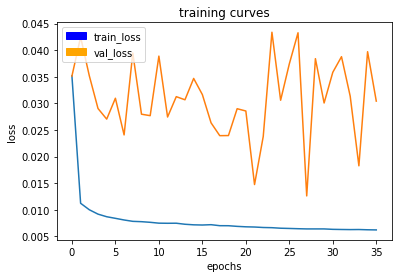

4816/4816 [==============================] - 2528s - loss: 0.0062 - val_loss: 0.0304
Epoch 37/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0062

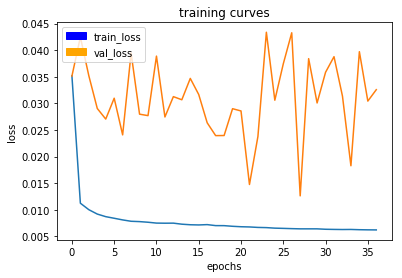

4816/4816 [==============================] - 2524s - loss: 0.0062 - val_loss: 0.0326
Epoch 38/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0062

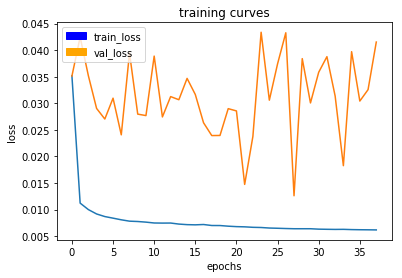

4816/4816 [==============================] - 2525s - loss: 0.0062 - val_loss: 0.0415
Epoch 39/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0062

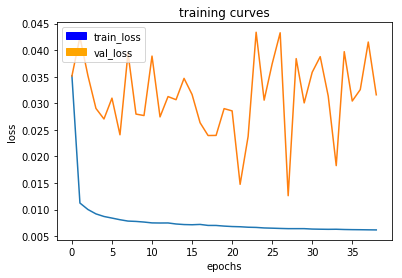

4816/4816 [==============================] - 2524s - loss: 0.0062 - val_loss: 0.0316
Epoch 40/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0061

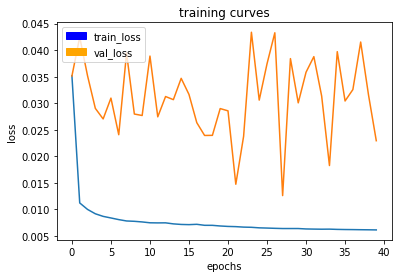

Epoch 00039: saving model to _training/cp-0039.ckpt
4816/4816 [==============================] - 2525s - loss: 0.0061 - val_loss: 0.0229
Epoch 41/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0061

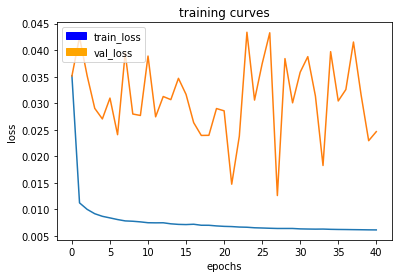

4816/4816 [==============================] - 2523s - loss: 0.0061 - val_loss: 0.0246
Epoch 42/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0061

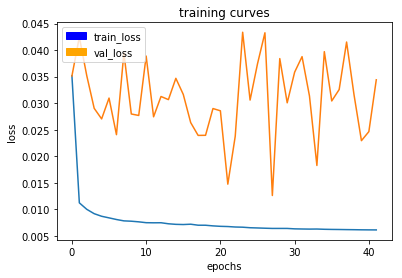

4816/4816 [==============================] - 2523s - loss: 0.0061 - val_loss: 0.0344
Epoch 43/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0061

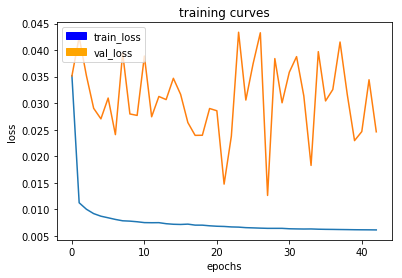

4816/4816 [==============================] - 2523s - loss: 0.0061 - val_loss: 0.0246
Epoch 44/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0061

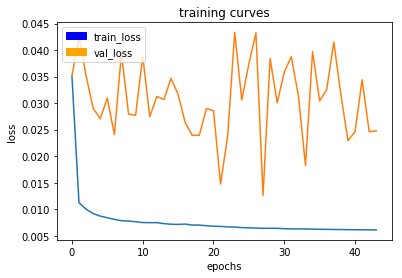

4816/4816 [==============================] - 2522s - loss: 0.0061 - val_loss: 0.0248
Epoch 45/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0061

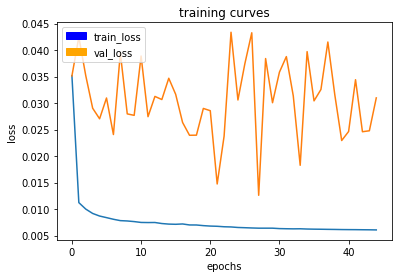

Epoch 00044: saving model to _training/cp-0044.ckpt
4816/4816 [==============================] - 2521s - loss: 0.0061 - val_loss: 0.0310
Epoch 46/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0061

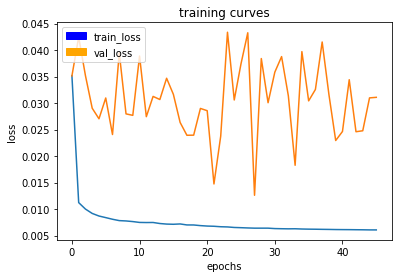

4816/4816 [==============================] - 2523s - loss: 0.0061 - val_loss: 0.0311
Epoch 47/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0061

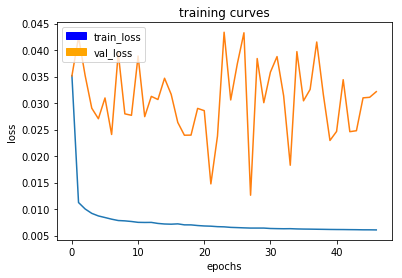

4816/4816 [==============================] - 2523s - loss: 0.0061 - val_loss: 0.0322
Epoch 48/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0060

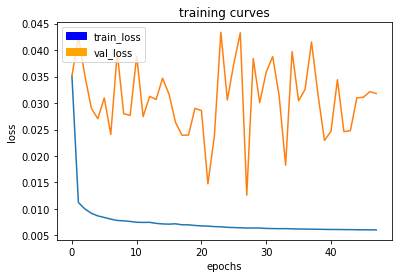

4816/4816 [==============================] - 2521s - loss: 0.0060 - val_loss: 0.0318
Epoch 49/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0061

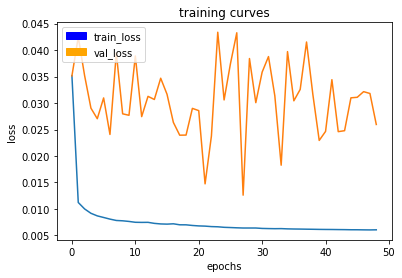

4816/4816 [==============================] - 2522s - loss: 0.0061 - val_loss: 0.0260
Epoch 50/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0060

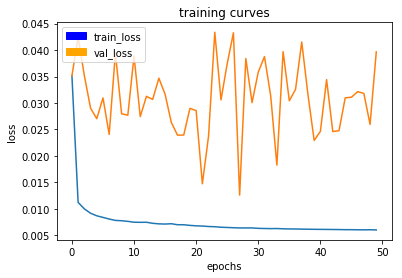

Epoch 00049: saving model to _training/cp-0049.ckpt
4816/4816 [==============================] - 2524s - loss: 0.0060 - val_loss: 0.0397
Epoch 51/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0060

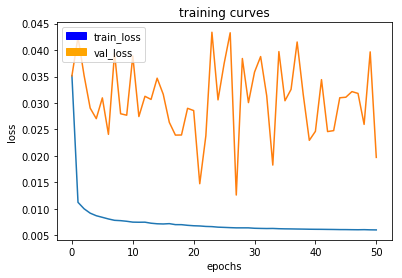

4816/4816 [==============================] - 2523s - loss: 0.0060 - val_loss: 0.0197
Epoch 52/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0060

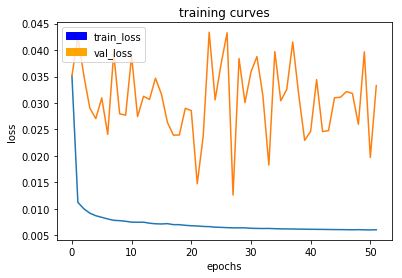

4816/4816 [==============================] - 2522s - loss: 0.0060 - val_loss: 0.0333
Epoch 53/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0060

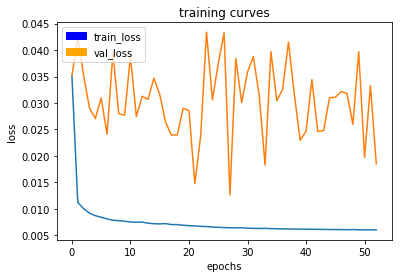

4816/4816 [==============================] - 2521s - loss: 0.0060 - val_loss: 0.0185
Epoch 54/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0060

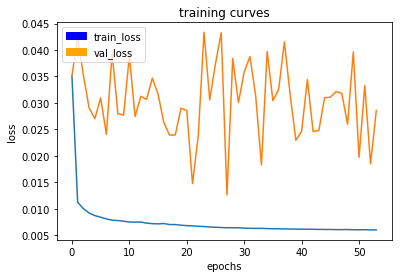

4816/4816 [==============================] - 2522s - loss: 0.0060 - val_loss: 0.0285
Epoch 55/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0060

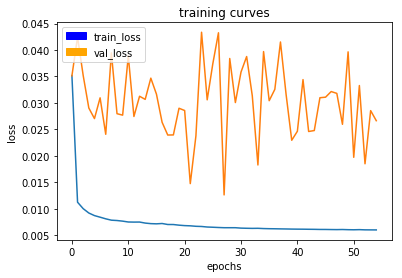

Epoch 00054: saving model to _training/cp-0054.ckpt
4816/4816 [==============================] - 2521s - loss: 0.0060 - val_loss: 0.0266
Epoch 56/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0060

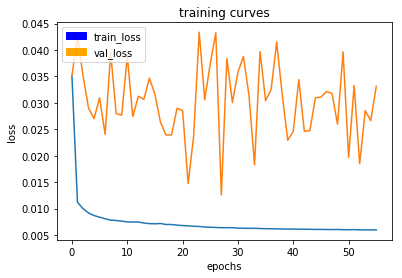

4816/4816 [==============================] - 2521s - loss: 0.0060 - val_loss: 0.0332
Epoch 57/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0060

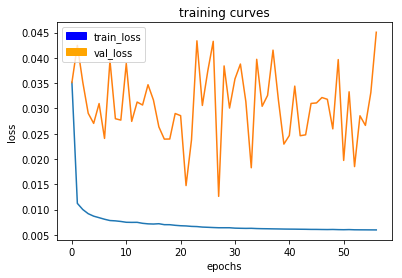

4816/4816 [==============================] - 2522s - loss: 0.0060 - val_loss: 0.0451
Epoch 58/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0060

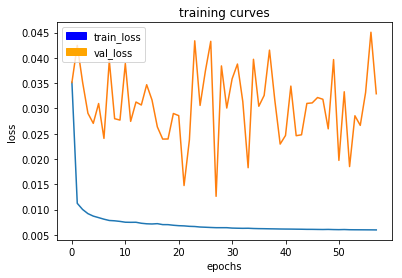

4816/4816 [==============================] - 2522s - loss: 0.0060 - val_loss: 0.0329
Epoch 59/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0060

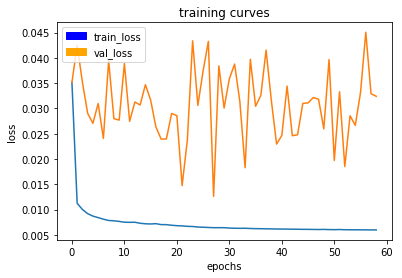

4816/4816 [==============================] - 2522s - loss: 0.0060 - val_loss: 0.0324
Epoch 60/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0059

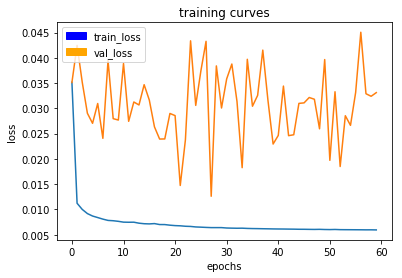

Epoch 00059: saving model to _training/cp-0059.ckpt
4816/4816 [==============================] - 2522s - loss: 0.0059 - val_loss: 0.0331
Epoch 61/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0059

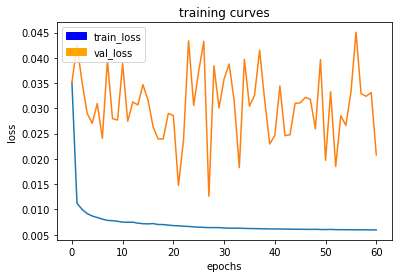

4816/4816 [==============================] - 2521s - loss: 0.0059 - val_loss: 0.0208
Epoch 62/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0060

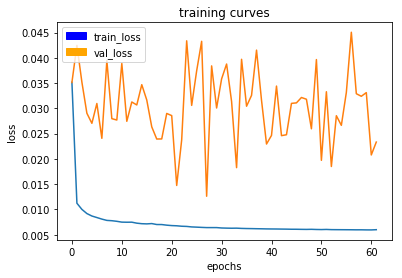

4816/4816 [==============================] - 2521s - loss: 0.0060 - val_loss: 0.0233
Epoch 63/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0060

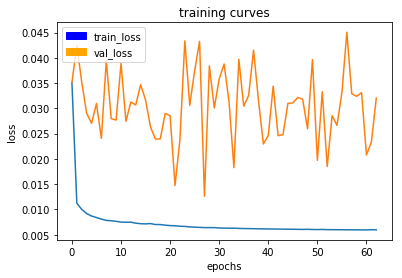

4816/4816 [==============================] - 2523s - loss: 0.0060 - val_loss: 0.0320
Epoch 64/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0059

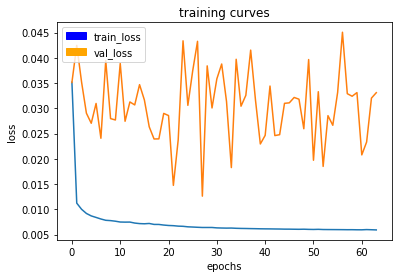

4816/4816 [==============================] - 2522s - loss: 0.0059 - val_loss: 0.0331
Epoch 65/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0059

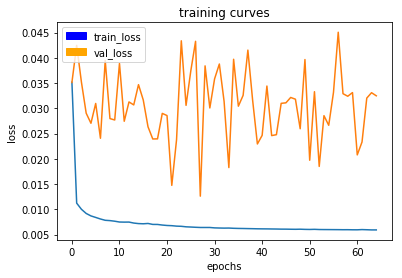

Epoch 00064: saving model to _training/cp-0064.ckpt
4816/4816 [==============================] - 2525s - loss: 0.0059 - val_loss: 0.0325
Epoch 66/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0059

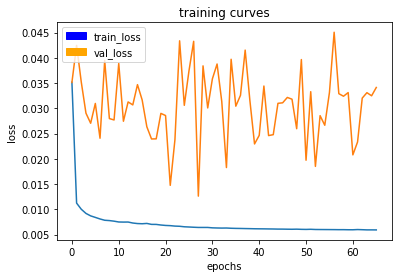

4816/4816 [==============================] - 2522s - loss: 0.0059 - val_loss: 0.0341
Epoch 67/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0059

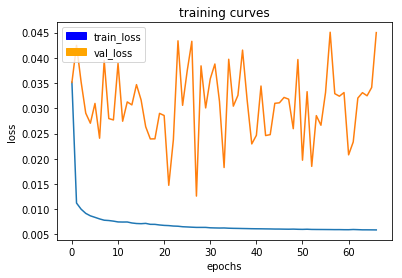

4816/4816 [==============================] - 2522s - loss: 0.0059 - val_loss: 0.0450
Epoch 68/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0059

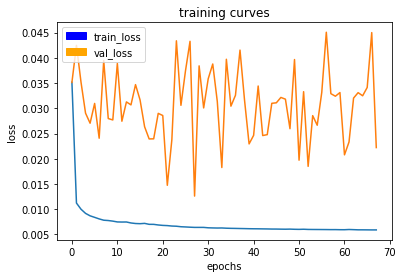

4816/4816 [==============================] - 2525s - loss: 0.0059 - val_loss: 0.0222
Epoch 69/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0059

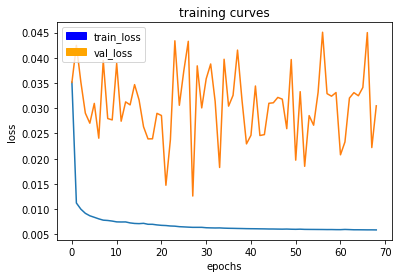

4816/4816 [==============================] - 2522s - loss: 0.0059 - val_loss: 0.0305
Epoch 70/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0059

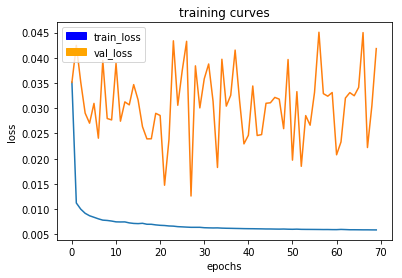

Epoch 00069: saving model to _training/cp-0069.ckpt
4816/4816 [==============================] - 2523s - loss: 0.0059 - val_loss: 0.0418
Epoch 71/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0059

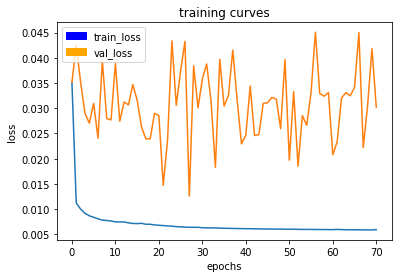

4816/4816 [==============================] - 2522s - loss: 0.0059 - val_loss: 0.0302
Epoch 72/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0059

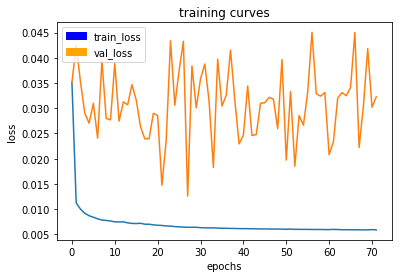

4816/4816 [==============================] - 2523s - loss: 0.0059 - val_loss: 0.0323
Epoch 73/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0059

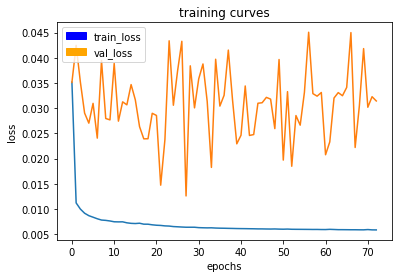

4816/4816 [==============================] - 2522s - loss: 0.0059 - val_loss: 0.0314
Epoch 74/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0059

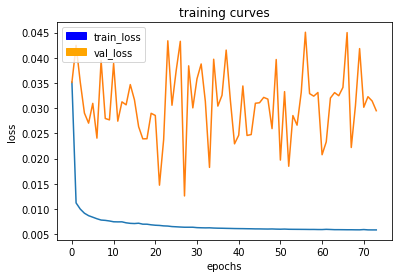

4816/4816 [==============================] - 2522s - loss: 0.0059 - val_loss: 0.0295
Epoch 75/75
4815/4816 [============================>.] - ETA: 0s - loss: 0.0059

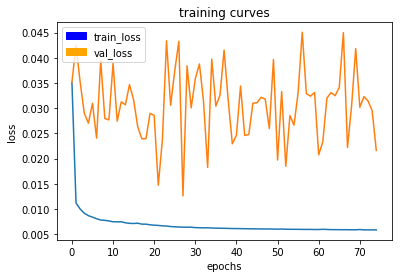

Epoch 00074: saving model to _training/cp-0074.ckpt
4816/4816 [==============================] - 2521s - loss: 0.0059 - val_loss: 0.0216


In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterx ators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)
# logger callback
logger_cb = plotting_tools.LoggerPlotter()

# saver callback
_checkpointPath = "_training/cp-{epoch:04d}.ckpt"
_checkpointDir = os.path.dirname( _checkpointPath )

saver_cb = keras.callbacks.ModelCheckpoint( _checkpointPath, 
                                            verbose = 1, 
                                            save_weights_only = True,
                                            period = 5 )

callbacks = [logger_cb, saver_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [ ]:
# Save your trained model weights
## weight_file_name = 'model_weights_vgg'
weight_file_name = 'model_weights_vgg'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [ ]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [ ]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

In [ ]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

In [ ]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

In [ ]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [ ]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

In [ ]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

In [ ]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

In [ ]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

In [ ]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

In [ ]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)